In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, integrate
from scipy.optimize import minimize_scalar

%precision 3
%matplotlib inline

In [2]:
def E(X, g=lambda x:x):
    x_range, f = X
    def integrand(x):
        return g(x) * f(x)
    return integrate.quad(integrand, -np.inf, np.inf)[0]

def V(X, g=lambda x:x):
    x_range, f = X
    mean = E(X, g)
    def integrand(x):
        return (g(x)-mean)**2 * f(x)
    return integrate.quad(integrand, -np.inf, np.inf)[0]

def check_prob(X):
    x_range, f = X
    f_min = minimize_scalar(f).fun
    assert f_min >= 0, 'density funcion is minus value'
    prob_sum = np.round(integrate.quad(f, -np.inf, np.inf)[0], 6)
    assert prob_sum == 1, f'sum of probability is {prob_sum}'
    print(f'expected value {E(X):.3}')
    print(f'variance {V(X):.3}')

def plot_prob(X, x_min, x_max):
    x_range, f = X
    def F(x):
        return integrate.quad(f, -np.inf, x)[0]
    
    xs = np.linspace(x_min, x_max, 100)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(xs, [f(x) for x in xs], label = 'f(x)', color = 'gray')
    ax.plot(xs, [F(x) for x in xs], label = 'F(x)', ls = '--', color = 'gray')
    
    ax.legend()
    plt.show()

# 1. 정규분포

### 정규분포의 밀도함수  
$ f(x) = {1 \over {\sqrt{2\pi}\sigma}} exp \left\{ - {{( x- \mu )^2} \over {2 \sigma ^2}} \right\} \  (-\infty \lt x \lt \infty ) $

### 정규분포의 기댓값과 분산  
$ X \sim N(\mu , \sigma^2)$일 때 $ E(X)=\mu, \ V(X) = \sigma ^2$

### 정규분포의 변환
$ X \sim N(\mu, \sigma^2)$일 때 실수 $a, \ b$에 대하여 $aX+b \sim N(a\mu+b, a^2\sigma^2)$

### 정의대로 구현

In [3]:
def N(mu, sigma):
    x_range = [-np.inf, np.inf]
    def f(x):
        return 1 / np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-mu)**2/(2*sigma**2))
    return x_range, f

mu, sigma = 2, 0.5
X = N(mu, sigma)

In [4]:
check_prob(X)

expected value 2.0
variance 0.25


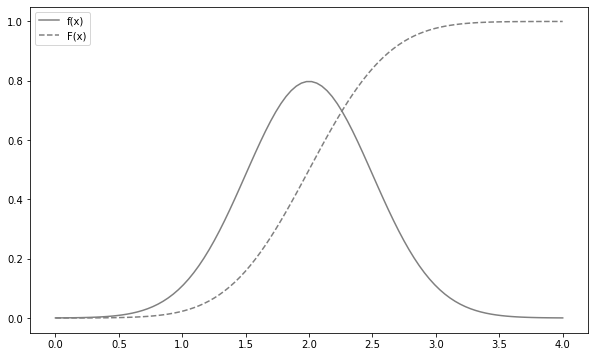

In [5]:
plot_prob(X, 0, 4)

### `scipy.stats`로 구현

In [6]:
rv = stats.norm(2, 0.5) # mu, sigma

In [7]:
rv.mean(), rv.var()

(2.0, 0.25)

 $ f(x) $ = `rv.pdf(x)`

In [8]:
rv.pdf(2)

0.7978845608028654

$ P(X \le x) $ = `rv.cdf(x)`

In [9]:
# P(X <= 1.7)의 값
rv.cdf(1.7)

0.27425311775007355

$ P(X \ge x) \ge \alpha$를 만족하는 $x$ 반환, 상위 $ 100 \times \alpha \%$ = `rv.isf(alpha)`

In [10]:
rv.isf(0.3)

2.2622002563540207

In [11]:
x = rv.isf(0.3)
rv.cdf(x)

0.7000000000000002

$ P(a \le x \le b) = \alpha $일 때 구간 $(a, b)$ 반환 = `rv.interval(alpha)`  
$ 100(1-\alpha)\%$ 구간은 $[ z_{1-\alpha /2}, z_{\alpha/2}]$

In [12]:
rv.interval(0.9)

(1.1775731865242636, 2.822426813475736)

In [13]:
rv.isf(0.95), rv.isf(0.05)

(1.1775731865242638, 2.8224268134757367)

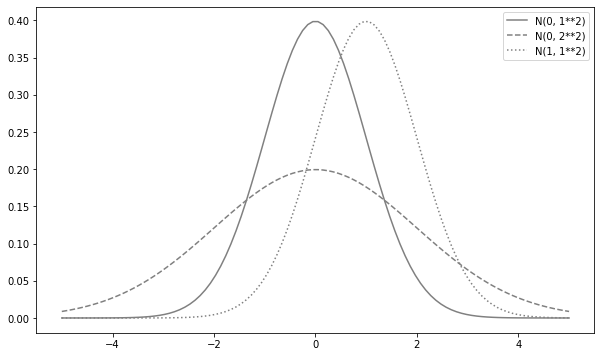

In [14]:
linestyles = ['-', '--', ':']

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

xs = np.linspace(-5, 5, 100)
params = [(0, 1), (0, 2), (1, 1)]
for param, ls in zip(params, linestyles):
    mu, sigma = param
    rv = stats.norm(mu, sigma)
    ax.plot(xs, rv.pdf(xs), label = f'N({mu}, {sigma}**2)', ls=ls, color='gray')
    
ax.legend()
plt.show()

# 2. 지수분포

$ f(x) = \begin{cases} \lambda e^{-\lambda x} & (x \ge 0) \\ 0 & (otherwise) \end{cases} $

단위시간당 평균 $\lambda$번 발생하는 사건의 발생 간격  
예) 하루 평균 2건의 교통사고가 발생하는 지역에서 하루 교통사고 발생 간격 = $Ex(2)$,  
3일 이내 다시 발생할 확률 = $P(X \le 3) = \int_0^3 2e^{-2x}dx \simeq 0.998$ 

※ 포아송 분포 : 단위시간당 사건이 발생하는 횟수 확률

### 기댓값, 분산
$ X \sim Ex(\lambda)$ 일 때 $ E(X) = {1 \over \lambda}, \ V(X) = {1 \over \lambda^2}$

### 정의대로 구현

In [15]:
def Ex(lam):
    x_range = [0, np.inf]
    def f(x):
        if x >= 0:
            return lam * np.exp(-lam * x)
        else:
            return 0
    return x_range, f

lam = 3
X = Ex(lam)

In [16]:
check_prob(X)

expected value 0.333
variance 0.111


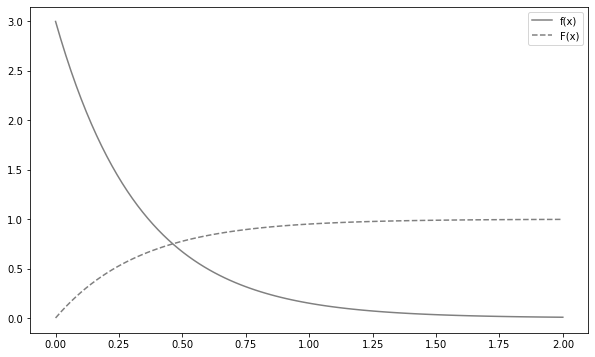

In [17]:
plot_prob(X, 0, 2)

### `scipy.stats`로 구현  
`stats.expon(scale = 1/lam)`

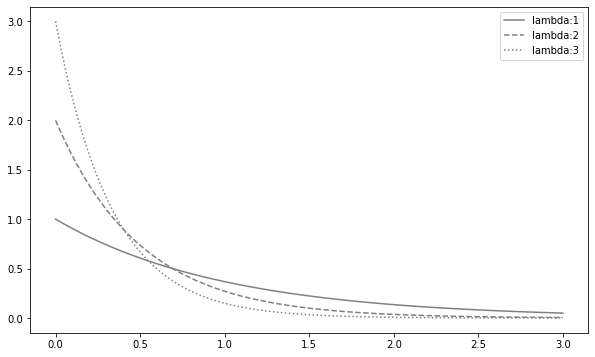

In [18]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)

xs = np.linspace(0, 3, 100)
for lam, ls in zip([1,2,3], linestyles):
    rv = stats.expon(scale = 1/lam)
    ax.plot(xs, rv.pdf(xs), label=f'lambda:{lam}', ls=ls, color='gray')

ax.legend()
plt.show()

# 3. 카이제곱분포

$Z_1, Z_2, ..., Z_n$이 서로 독립이고 $N(0, 1)$을 따를 때  
$Y = \sum _{i=1}^{n}Z_i^2$의 확률분포를 자유도가 $n$인 카이제곱분포라고 한다.

In [19]:
n = 10 # 자유도
rv = stats.norm()
sample_size = int(1e6)
# 표준정규분포에서 표본크기 100만으로 무작위추출
Zs_sample = rv.rvs((n, sample_size))
# axis=0에서 총합을 구하고, 표준정규분포의 제곱합 표본 데이터 구하기
chi2_sample = np.sum(Zs_sample**2, axis=0)

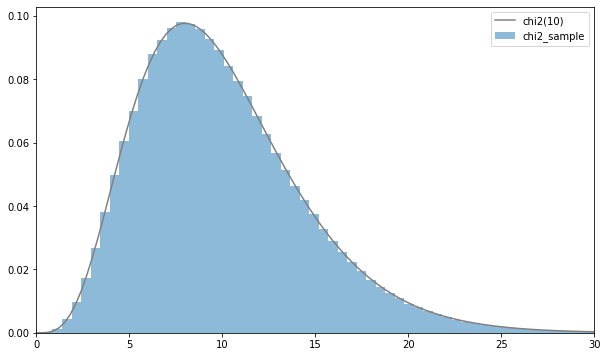

In [20]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

rv_true = stats.chi2(n)
xs = np.linspace(0, 30, 100)
ax.hist(chi2_sample, bins=100, density=True, alpha=0.5, label='chi2_sample')
ax.plot(xs, rv_true.pdf(xs), label=f'chi2({n})', color='gray')

ax.legend()
ax.set_xlim(0, 30)
plt.show()

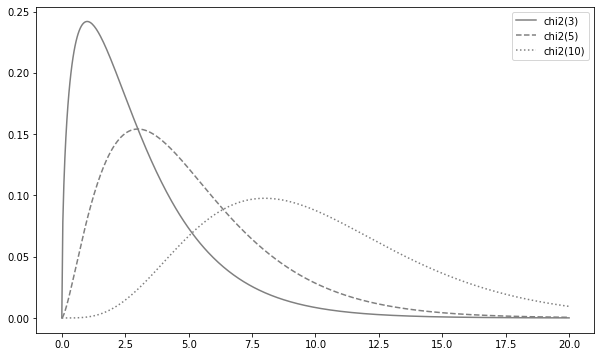

In [21]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

xs = np.linspace(0, 20, 500)
for n, ls in zip([3, 5, 10], linestyles):
    rv = stats.chi2(n)
    ax.plot(xs, rv.pdf(xs), label=f'chi2({n})', ls=ls, color='gray')

ax.legend()
plt.show()

### 특징  
- 좌우 비대칭, 왼쪽으로 치우침
- 자유도가 커지면 좌우대칭에 가까워짐
- 자유도의 값 가까이에 분포의 정점이 있음

상위 $100\alpha\%$ = $\chi_{\alpha}^2(n)$

In [22]:
rv = stats.chi2(5) # 자유도 5
rv.isf(0.05) # 상위 5%

11.070497693516355

# 4. t분포

확률변수 $Z, Y$는 서로 독립이고 $Z\sim N(0,1), \ Y\sim \chi^2(n)$일 때  
$t={Z \over \sqrt{Y/n}}$

In [23]:
n = 10
rv1 = stats.norm()
rv2 = stats.chi2(n)

sample_size = int(1e6)
Z_sample = rv1.rvs(sample_size)
chi2_sample = rv2.rvs(sample_size)

t_sample = Z_sample / np.sqrt(chi2_sample/n)

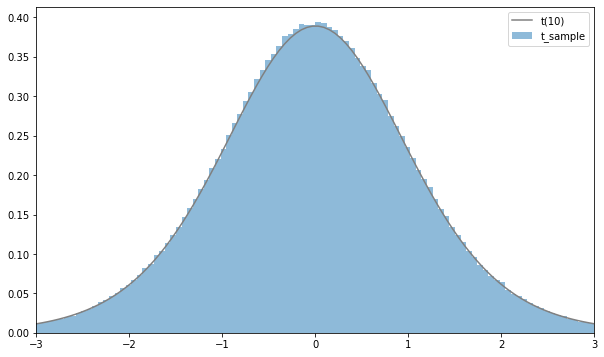

In [24]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

rv = stats.t(n)
xs = np.linspace(-3, 3, 100)
ax.hist(t_sample, bins=100, range=(-3,3), density=True, alpha=0.5, label='t_sample')
ax.plot(xs, rv.pdf(xs), label=f't({n})', color='gray')

ax.legend()
ax.set_xlim(-3, 3)
plt.show()

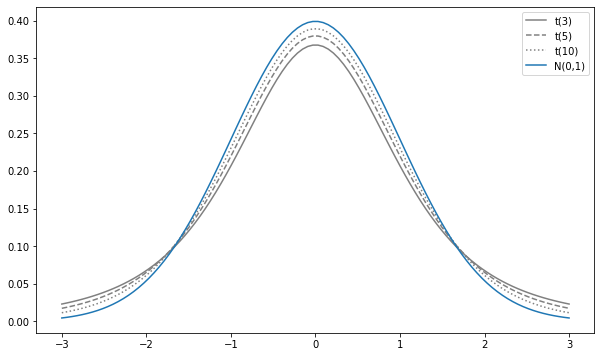

In [25]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

xs = np.linspace(-3, 3, 100)
for n, ls in zip([3, 5, 10], linestyles):
    rv = stats.t(n)
    ax.plot(xs, rv.pdf(xs), label=f't({n})', ls=ls, color='gray')
rv=stats.norm()
ax.plot(xs, rv.pdf(xs), label='N(0,1)')
    
ax.legend()
plt.show()

### 특징  
- 좌우대칭
- 정점이 표준정규분포보다 낮음 (양쪽 끝이 표준정규분포보다 두꺼움)
- 자유도가 커질수록 표준정규분포에 가까워짐

상위 $100\alpha\%$ = $t_{\alpha}(n)$

In [26]:
rv = stats.t(5)
rv.isf(0.05)

2.0150483726691575

# 5. F분포

$ Y_1, Y_2$가 독립이고 각각 $Y_1 \sim \chi ^2(n_1), \ Y_2 \sim \chi ^2(n_2)$일 때  
$F={{Y_1/n_1} \over {Y_2/n_2}}$

In [27]:
n1, n2= 5, 10
rv1 = stats.chi2(n1)
rv2 = stats.chi2(n2)

sample_size = int(1e6)
sample1 = rv1.rvs(sample_size)
sample2 = rv2.rvs(sample_size)

f_sample = (sample1/n1) / (sample2/n2)

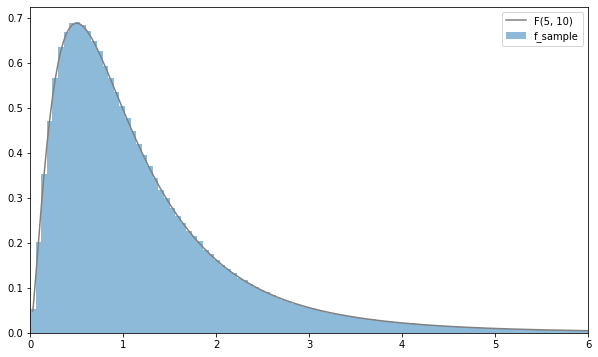

In [29]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

rv = stats.f(n1, n2)
xs = np.linspace(0, 6, 200)[1:]
ax.hist(f_sample, bins=100, range=(0,6), density=True, alpha=0.5, label='f_sample')
ax.plot(xs, rv.pdf(xs), label=f'F({n1}, {n2})', color='gray')

ax.legend()
ax.set_xlim(0, 6)
plt.show()

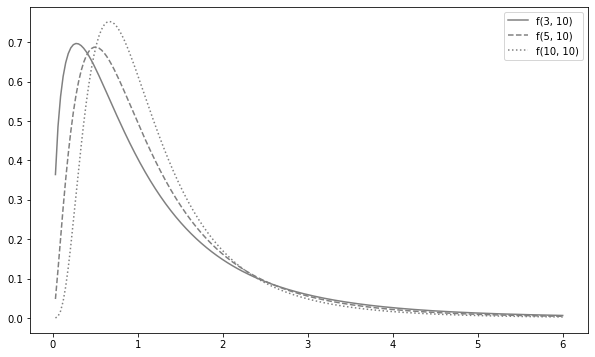

In [30]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

xs = np.linspace(0, 6, 200)[1:]
for n1, ls in zip([3, 5, 10], linestyles):
    rv = stats.f(n1, 10)
    ax.plot(xs, rv.pdf(xs), label=f'f({n1}, 10)', ls=ls, color='gray')
    
ax.legend()
plt.show()

### 특징
- 좌우비대칭, 왼쪽으로 치우침
- 분포의 정점이 1에 가까움